In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [2]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Pneumonia (TB) Identification using Explainable AI\TB_Chest_Radiography_Database", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 540 files [00:00, 626.11 files/s]


In [3]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [4]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [5]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
2 folder and 0 images in output\test
0 folder and 11 images in output\test\Normal
0 folder and 17 images in output\test\Tuberculosis
2 folder and 0 images in output\train
0 folder and 162 images in output\train\Normal
0 folder and 243 images in output\train\Tuberculosis
2 folder and 0 images in output\val
0 folder and 43 images in output\val\Normal
0 folder and 64 images in output\val\Tuberculosis


In [6]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (512, 512, 3)


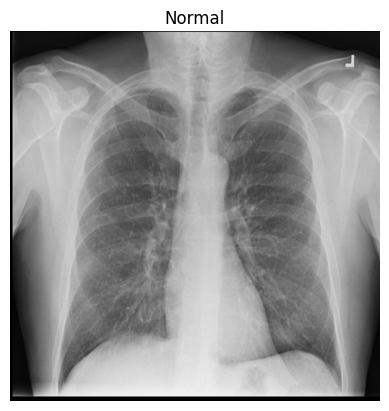

In [7]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Normal')

Image Shape : (512, 512)


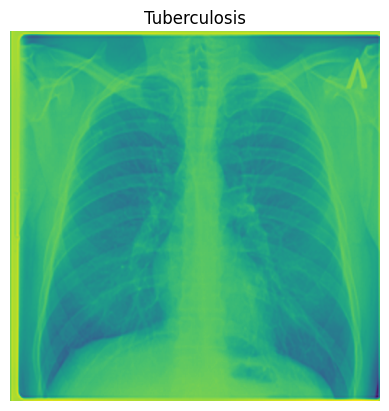

In [8]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Tuberculosis')

In [9]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [10]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 405 images belonging to 2 classes.
Found 107 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [11]:
train_data.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [12]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [13]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (405,)
val_y.shape:  (107,)
test_y.shape:  (28,)


In [14]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [15]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(2)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,039,554 (26.85 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [17]:
plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10


C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.5096 - loss: 0.9540 - val_accuracy: 0.5047 - val_loss: 0.7429
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.5261 - loss: 0.7395 - val_accuracy: 0.7103 - val_loss: 0.6086
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.6632 - loss: 0.6163 - val_accuracy: 0.6822 - val_loss: 0.5747
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.7662 - loss: 0.5285 - val_accuracy: 0.8879 - val_loss: 0.4547
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8087 - loss: 0.4690 - val_accuracy: 0.8505 - val_loss: 0.4255
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.8326 - loss: 0.4027 - val_accuracy: 0.8692 - val_loss: 0.3693
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.8538 - loss: 0.3736 - val_accuracy: 0.8692 - val_loss: 0.3564
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - accuracy: 0.8829 - loss: 0.3487 - val_accuracy: 0.8692 - val_loss: 0.3328
Epoch 9/10
7/7 ━━━━

In [19]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

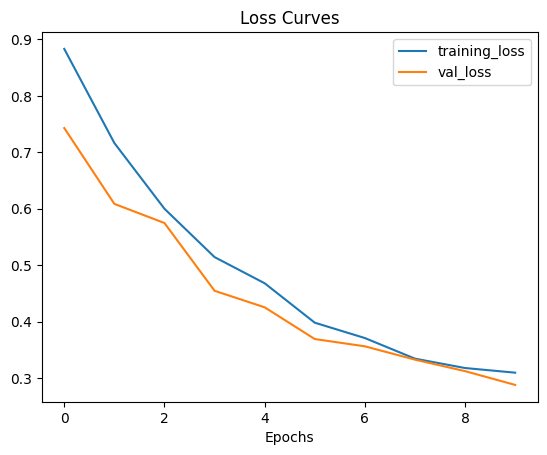

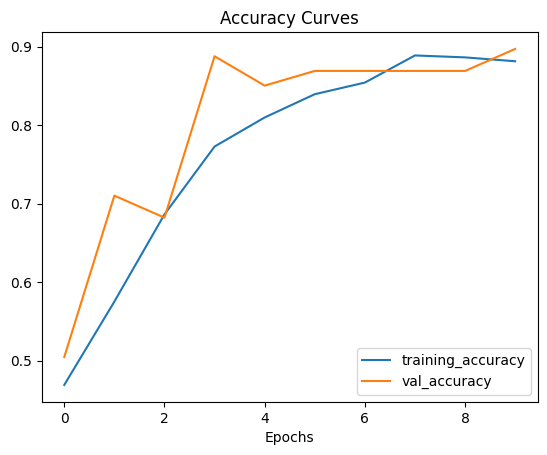

In [20]:
plot_loss_curves(history)

In [21]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step
              precision    recall  f1-score   support

           0       0.91      0.85      0.88        46
           1       0.89      0.93      0.91        61

    accuracy                           0.90       107
   macro avg       0.90      0.89      0.89       107
weighted avg       0.90      0.90      0.90       107



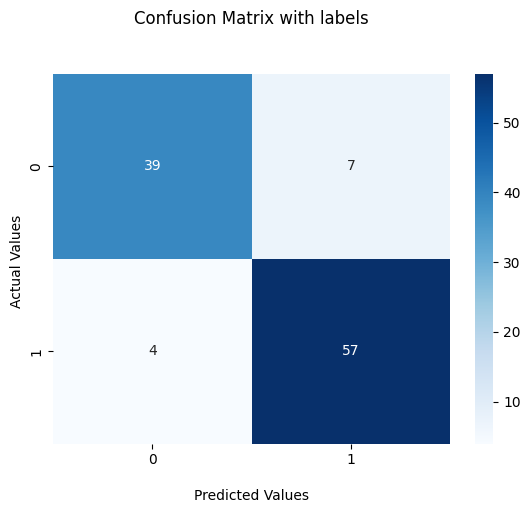

In [22]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [23]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.94      0.94      0.94        17

    accuracy                           0.93        28
   macro avg       0.93      0.93      0.93        28
weighted avg       0.93      0.93      0.93        28



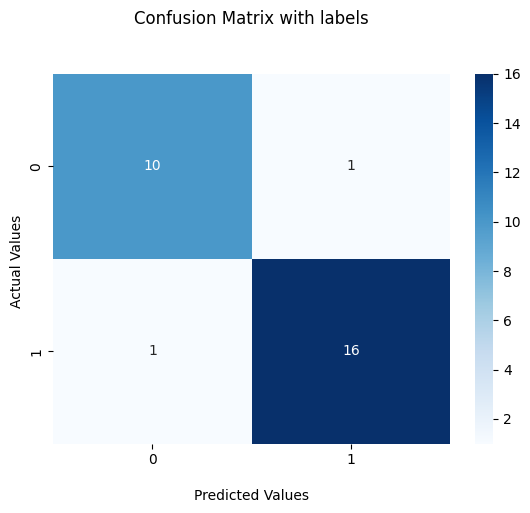

In [24]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [25]:
model.save('my_model.keras')

In [26]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: Tuberculosis


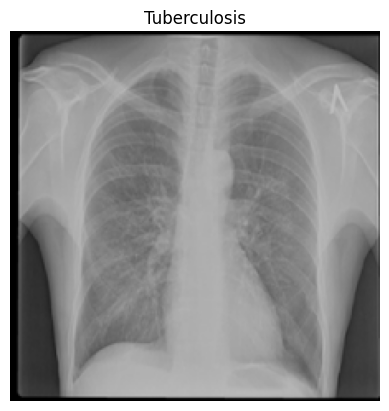

In [27]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Pneumonia (TB) Identification using Explainable AI\TB_Chest_Radiography_Database\Tuberculosis\Tuberculosis-18.png"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Normal', 'Tuberculosis']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()


In [ ]:

import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


# data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'
# Image dimensions and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
val_data = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

# Function to create a model using a pre-trained base
def create_model(base_model_name):
    if base_model_name == "VGG16":
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == "ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Invalid base model name. Choose 'VGG16' or 'ResNet50'.")
    
    base_model.trainable = False  # Freeze the pre-trained layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(train_data.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Train and save the VGG16 model
vgg16_model = create_model("VGG16")
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

print("Training VGG16 Model...")
vgg16_model.fit(train_data, epochs=30, validation_data=val_data)
vgg16_model.save("vgg16_model.h5")
print("VGG16 Model saved as 'vgg16_model.h5'.")

# Train and save the ResNet50 model
resnet50_model = create_model("ResNet50")
resnet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

print("Training ResNet50 Model...")
resnet50_model.fit(train_data, epochs=30, validation_data=val_data)
resnet50_model.save("resnet50_model.h5")
print("ResNet50 Model saved as 'resnet50_model.h5'.")


Found 405 images belonging to 2 classes.
Found 107 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Training VGG16 Model...
Epoch 1/10


C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 132s 10s/step - accuracy: 0.5725 - loss: 0.7581 - val_accuracy: 0.7757 - val_loss: 0.5045
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 118s 9s/step - accuracy: 0.7136 - loss: 0.5367 - val_accuracy: 0.9065 - val_loss: 0.3662
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - accuracy: 0.8406 - loss: 0.4078 - val_accuracy: 0.8785 - val_loss: 0.3308
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step - accuracy: 0.8656 - loss: 0.3567 - val_accuracy: 0.9065 - val_loss: 0.2773
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 111s 9s/step - accuracy: 0.8790 - loss: 0.3091 - val_accuracy: 0.9065 - val_loss: 0.2557
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - accuracy: 0.8748 - loss: 0.3158 - val_accuracy: 0.9252 - val_loss: 0.2441
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 108s 8s/step - accuracy: 0.8959 - loss: 0.2622 - val_accuracy: 0.9159 - val_loss: 0.2243
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - accuracy: 0.9347 - loss: 0.2293 - val_accuracy: 0.9159 - val_loss: 0.

VGG16 Model saved as 'vgg16_model.h5'.
Training ResNet50 Model...
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.5366 - loss: 0.8416 - val_accuracy: 0.5981 - val_loss: 0.8530
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5925 - loss: 0.8049 - val_accuracy: 0.5981 - val_loss: 0.6609
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6084 - loss: 0.7101 - val_accuracy: 0.5981 - val_loss: 0.6387
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6191 - loss: 0.6501 - val_accuracy: 0.5421 - val_loss: 0.6838
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5430 - loss: 0.6964 - val_accuracy: 0.5888 - val_loss: 0.6708
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.5179 - loss: 0.6868 - val_accuracy: 0.5981 - val_loss: 0.6810
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.5976 - loss: 0.6807 - val_accuracy: 0.6262 - val_loss: 0.6427
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - 

ResNet50 Model saved as 'resnet50_model.h5'.
